<a href="https://colab.research.google.com/github/Mbapat2211/Image-Classifiers/blob/master/Transfer_Learning_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all the header files
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Obtaining the dataset folder from drive 
train_dir = '/content/drive/My Drive/CNN Image Classifier/CNN Memes-V-Notes/Train'
test_dir = '/content/drive/My Drive/CNN Image Classifier/CNN Memes-V-Notes/Test'
val_dir = '/content/drive/My Drive/CNN Image Classifier/CNN Memes-V-Notes/Validation'

dirs= {'train': train_dir, 
       'test': test_dir,
       'valid': val_dir
      }

In [ ]:
mean = np.array([0.485, 0.456, 0.496]) 
std = np.array([0.229, 0.224, 0.225])

# Using the standarized values obtained from the imagenet dataset

In [ ]:
# For aplying transformations
# Resize: to convert all images to the same size
# ToTensor: to convert the images into a tensor
# Normalize: to get the image parameters in between 0 and 1

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
# Loading the image through Image Loaders

image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x])for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [ ]:
labels_names = ['Memes','Notes']

In [ ]:
# For displaying the images

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean                       # Converting the images into standard form for displaying
    inp = np.clip(inp, 0, 1)                     
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Running the program on the gpu

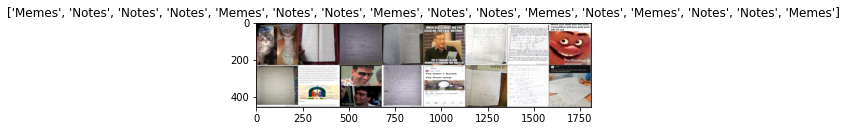

In [ ]:
# Getting a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

# Dispalying the image along with their labels 
imshow(out, title=[labels_names[x] for x in classes])

In [ ]:
# Loading the pretrained resnet50 model
model = models.resnet50(pretrained = True)

In [ ]:
input_feat = model.fc.in_features # Getting the input features from the model
model.fc = nn.Linear(input_feat, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch will have a training, testing and validation phase
        for phase in ['train', 'test', 'valid']:
            if phase == 'train':
                model.train()  # Setting model to training mode
            else:
                model.eval()   # Setting model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Tracking history for train phase
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize 
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # calculating the loss
                running_loss += loss.item() * inputs.size(0)
                # calculating the accuracy
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()
    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma= 0.1)

In [ ]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4202 Acc: 0.8901
test Loss: 0.2158 Acc: 1.0000
valid Loss: 0.2423 Acc: 0.9688

Epoch 1/9
----------
train Loss: 0.1739 Acc: 0.9842
test Loss: 0.1021 Acc: 1.0000
valid Loss: 0.1303 Acc: 0.9688

Epoch 2/9
----------
train Loss: 0.1241 Acc: 0.9875
test Loss: 0.0987 Acc: 1.0000
valid Loss: 0.1213 Acc: 0.9688

Epoch 3/9
----------
train Loss: 0.1238 Acc: 0.9862
test Loss: 0.0933 Acc: 1.0000
valid Loss: 0.1155 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.1192 Acc: 0.9875
test Loss: 0.0905 Acc: 1.0000
valid Loss: 0.1186 Acc: 0.9688

Epoch 5/9
----------
train Loss: 0.1199 Acc: 0.9868
test Loss: 0.0938 Acc: 1.0000
valid Loss: 0.1145 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.1156 Acc: 0.9888
test Loss: 0.0909 Acc: 1.0000
valid Loss: 0.1118 Acc: 0.9688

Epoch 7/9
----------
train Loss: 0.1126 Acc: 0.9875
test Loss: 0.0937 Acc: 1.0000
valid Loss: 0.1165 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.1263 Acc: 0.9862
test Loss: 0.0901 Acc: 1.0000
valid 